# SVM prediction for the best features

In [47]:
import numpy as np  # for handling multi-dimensional array operation
import pandas as pd  # for reading data from csv 
import statsmodels.api as sm  # for finding the p-value
from sklearn.preprocessing import MinMaxScaler  # for normalization
from sklearn.model_selection import train_test_split as tts
from sklearn.metrics import accuracy_score 
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import classification_report
from sklearn.metrics import precision_recall_curve
from sklearn.utils import shuffle
from sklearn import svm
from sklearn.ensemble import GradientBoostingClassifier
from numpy import mean
from sklearn.model_selection import GridSearchCV
from imblearn.pipeline import Pipeline
from imblearn.pipeline import make_pipeline
from imblearn.combine import SMOTETomek
from imblearn.under_sampling import TomekLinks
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_validate
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import plot_confusion_matrix

In [48]:
#LOAD DATA 
data = pd.read_csv('./bestfeatures24.csv')

#EXTRACT FEATURES AND LABELS
Y = data['aki_flag'] 
X = data.iloc[:,2:] 

#CREATE DUMMY VARIABLES FOR GENDER
X = pd.get_dummies(X)

#FILL MISSING WITH MEAN IMPUTATION
X = X.fillna(X.mean())

#NORMALIZATION WITH MIN-MAX SCALER 0-1
scaler = MinMaxScaler()
X = scaler.fit_transform(X)

#SPLIT DATASET INTO TRAINING AND TESTING SETS
X_train, X_test, y_train, y_test = tts(X, Y, test_size=0.3, random_state=42)

In [49]:
#APPLY THE SMOTE TOMEK-LINKS TECHNIQUE TO COPE WITH CLASS IMBALANCE PROBLEM 
resample = SMOTETomek(tomek=TomekLinks(sampling_strategy='majority'))

#TEST ALL THE BEST MODELS TO SEE WHICH ONE IS THE BEST AMONG THE BEST ONES.
params = [
    {'C': [0.1], 'degree': [1], 'kernel': ['poly']},
    {'C': [10], 'degree': [2], 'kernel':['poly']},
    {'C': [10], 'gamma': [1], 'kernel':['rbf']},
] 

In [50]:
gs = GridSearchCV(svm.SVC(), params, refit = True, verbose = 3)
p = Pipeline(steps=[('r', resample), ('gs', gs)])

In [18]:
gs.fit(X_train, y_train)

Fitting 5 folds for each of 3 candidates, totalling 15 fits
[CV 1/5] END ......C=0.1, degree=1, kernel=poly;, score=0.705 total time= 1.0min
[CV 2/5] END ......C=0.1, degree=1, kernel=poly;, score=0.705 total time= 1.0min
[CV 3/5] END ......C=0.1, degree=1, kernel=poly;, score=0.705 total time= 1.0min
[CV 4/5] END ......C=0.1, degree=1, kernel=poly;, score=0.705 total time= 1.0min
[CV 5/5] END ......C=0.1, degree=1, kernel=poly;, score=0.705 total time= 1.1min
[CV 1/5] END .......C=10, degree=2, kernel=poly;, score=0.712 total time= 1.4min
[CV 2/5] END .......C=10, degree=2, kernel=poly;, score=0.717 total time= 1.4min
[CV 3/5] END .......C=10, degree=2, kernel=poly;, score=0.708 total time= 1.4min
[CV 4/5] END .......C=10, degree=2, kernel=poly;, score=0.708 total time= 1.5min
[CV 5/5] END .......C=10, degree=2, kernel=poly;, score=0.706 total time= 1.4min
[CV 1/5] END .........C=10, gamma=1, kernel=rbf;, score=0.701 total time= 1.9min
[CV 2/5] END .........C=10, gamma=1, kernel=rbf;,

GridSearchCV(estimator=SVC(),
             param_grid=[{'C': [0.1], 'degree': [1], 'kernel': ['poly']},
                         {'C': [10], 'degree': [2], 'kernel': ['poly']},
                         {'C': [10], 'gamma': [1], 'kernel': ['rbf']}],
             verbose=3)

In [19]:
print("The best parameters found for the 24h DCW:")
print(gs.best_params_)
  
#PRINT HOW OUR MODEL LOOKS AFTER HYPER-PARAMETER TUNING
print("The best estimator found for the 24h DCW:")
print(gs.best_estimator_)

The best parameters found for the 24h DCW:
{'C': 10, 'degree': 2, 'kernel': 'poly'}
The best estimator found for the 24h DCW:
SVC(C=10, degree=2, kernel='poly')


In [51]:
#DEFINE THE METRICS 
scoring=['accuracy','precision','recall', 'roc_auc', 'f1']

bestmodel = svm.SVC(C=10, degree=2, kernel='poly')

In [44]:
p = Pipeline(steps=[('r', resample), ('m', bestmodel)])

scores = cross_validate(p, X, Y, scoring = scoring, cv = 5)

In [45]:
scores

{'fit_time': array([447.75107503, 446.80903649, 452.62903166, 448.54986262,
        446.87129903]),
 'score_time': array([76.70580482, 76.97911024, 76.44187975, 77.14399052, 76.15294075]),
 'test_accuracy': array([0.64605823, 0.64900229, 0.63645288, 0.65379581, 0.63776178]),
 'test_precision': array([0.43550725, 0.43823529, 0.4261242 , 0.44236527, 0.42234124]),
 'test_recall': array([0.66482301, 0.65856354, 0.66039823, 0.65376106, 0.61061947]),
 'test_roc_auc': array([0.67369415, 0.67980499, 0.66931564, 0.67639847, 0.65638262]),
 'test_f1': array([0.5262697 , 0.52626932, 0.51800434, 0.52767857, 0.49932157])}

In [46]:
scores['test_accuracy'].mean()

0.644614197610154

In [47]:
scores['test_precision'].mean()

0.43291464928748047

In [48]:
scores['test_recall'].mean()

0.6496330611646213

In [49]:
scores['test_f1'].mean()

0.5195087003443603

In [50]:
scores['test_roc_auc'].mean()

0.6711191729612345

Elapsed time to compute the importances: 0.066 seconds


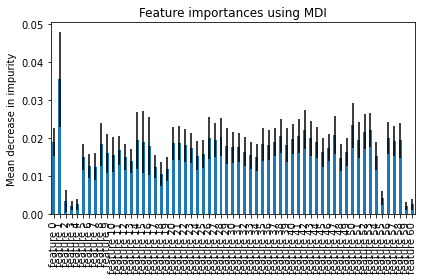

In [37]:
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt

#FEATURES SELECTION BASED ON THEIR IMPORTANCE WITH A RANDOM FOREST CLASSIFIER 
feature_names = [f'feature {i}' for i in range(X.shape[1])]
forest = RandomForestClassifier(random_state=0)
forest.fit(X_train, y_train)

import time

start_time = time.time()
importances = forest.feature_importances_
std = np.std([
    tree.feature_importances_ for tree in forest.estimators_], axis=0)
elapsed_time = time.time() - start_time

print(f"Elapsed time to compute the importances: "
      f"{elapsed_time:.3f} seconds")

forest_importances = pd.Series(importances, index = feature_names)

fig, ax = plt.subplots()
forest_importances.plot.bar(yerr=std, ax=ax)
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()


In [28]:
for i,v in enumerate(importances):
    print('Feature: %0d, Score: %.5f' % (i,v))

Feature: 0, Score: 0.01881
Feature: 1, Score: 0.03538
Feature: 2, Score: 0.00341
Feature: 3, Score: 0.00217
Feature: 4, Score: 0.00256
Feature: 5, Score: 0.01497
Feature: 6, Score: 0.01269
Feature: 7, Score: 0.01245
Feature: 8, Score: 0.01827
Feature: 9, Score: 0.01588
Feature: 10, Score: 0.01551
Feature: 11, Score: 0.01675
Feature: 12, Score: 0.01493
Feature: 13, Score: 0.01392
Feature: 14, Score: 0.01934
Feature: 15, Score: 0.01883
Feature: 16, Score: 0.01783
Feature: 17, Score: 0.01237
Feature: 18, Score: 0.01056
Feature: 19, Score: 0.01186
Feature: 20, Score: 0.01860
Feature: 21, Score: 0.01855
Feature: 22, Score: 0.01798
Feature: 23, Score: 0.01738
Feature: 24, Score: 0.01527
Feature: 25, Score: 0.01583
Feature: 26, Score: 0.01993
Feature: 27, Score: 0.01936
Feature: 28, Score: 0.02021
Feature: 29, Score: 0.01793
Feature: 30, Score: 0.01746
Feature: 31, Score: 0.01754
Feature: 32, Score: 0.01636
Feature: 33, Score: 0.01539
Feature: 34, Score: 0.01491
Feature: 35, Score: 0.01827
Fe

In [35]:
data.columns[2:]

Index(['age', 'gender', 'diuretics', 'congestive_heart_failure', 'diabetes',
       'hypertension', 'avg_bicarbonate', 'min_bicarbonate', 'max_bicarbonate',
       'avg_bun', 'min_bun', 'max_bun', 'avg_chloride', 'min_chloride',
       'max_chloride', 'avg_scr', 'min_scr', 'max_scr', 'avg_inr', 'min_inr',
       'max_inr', 'avg_platelets', 'min_platelets', 'max_platelets',
       'avg_potassium', 'min_potassium', 'max_potassium', 'avg_ptt', 'min_ptt',
       'max_ptt', 'avg_wbc', 'min_wbc', 'max_wbc', 'avg_calcium',
       'min_calcium', 'max_calcium', 'avg_meanbp', 'min_meanbp', 'max_meanbp',
       'avg_heart_rate', 'min_heart_rate', 'max_heart_rate', 'avg_sysbp',
       'min_sysbp', 'max_sysbp', 'avg_diasbp', 'min_diasbp', 'max_diasbp',
       'avg_resp', 'min_resp', 'max_resp', 'avg_temp', 'min_temp', 'max_temp',
       'avg_spo2', 'min_spo2', 'max_spo2', 'avg_glucose', 'min_glucose',
       'max_glucose'],
      dtype='object')

Calculate the AUPRC now. 

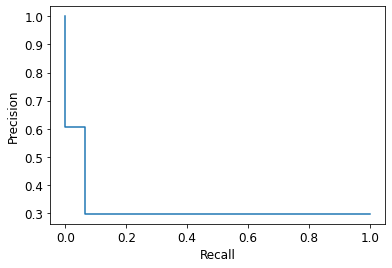

In [52]:
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import PrecisionRecallDisplay

bestmodel.fit(X_train, y_train)
ypred_svm = bestmodel.predict(X_test)
prec, recall, _ = precision_recall_curve(y_test, ypred_svm,
                                         pos_label=bestmodel.classes_[1])
pr_display = PrecisionRecallDisplay(precision=prec, recall=recall).plot()


In [ ]:
mean(prec)

In [ ]:
mean(recall)

In [53]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, ypred_svm)
cm

array([[3166,   56],
       [1277,   86]])

In [54]:
print('Confusion matrix\n\n', cm)
print('\nTrue Positives(TP) = ', cm[0,0])
print('\nTrue Negatives(TN) = ', cm[1,1])
print('\nFalse Positives(FP) = ', cm[0,1])
print('\nFalse Negatives(FN) = ', cm[1,0])
print(classification_report(y_test,ypred_svm))

Confusion matrix

 [[3166   56]
 [1277   86]]

True Positives(TP) =  3166

True Negatives(TN) =  86

False Positives(FP) =  56

False Negatives(FN) =  1277
              precision    recall  f1-score   support

           0       0.71      0.98      0.83      3222
           1       0.61      0.06      0.11      1363

    accuracy                           0.71      4585
   macro avg       0.66      0.52      0.47      4585
weighted avg       0.68      0.71      0.61      4585



In [57]:
from sklearn.metrics import roc_curve
from sklearn.metrics import RocCurveDisplay


# GBDT prediction for the best features

In [30]:
#TEST ALL THE BEST MODELS TO SEE WHICH ONE IS THE BEST AMONG THE BEST ONES.
params_gb = [
   {'learning_rate':[0.25], 'max_depth':[1], 'n_estimators':[250]},
    {'learning_rate':[0.01], 'max_depth':[3], 'n_estimators':[100]},
    {'learning_rate':[0.01], 'max_depth':[5], 'n_estimators':[100]},
    {'learning_rate':[0.1], 'max_depth':[1], 'n_estimators': [100]},
    {'learning_rate':[0.1], 'max_depth':[1], 'n_estimators':[250]},
    {'learning_rate':[0.01], 'max_depth':[4]},
    {'learning_rate':[0.01], 'max_depth':[1]},
    {'learning_rate':[0.05], 'max_depth':[1]}
] 

In [31]:
gs_gb = GridSearchCV(GradientBoostingClassifier(), params_gb, refit = True, verbose = 3)
p_gb = Pipeline(steps=[('r', resample), ('gs', gs_gb)])

In [53]:
gs_gb.fit(X_train, y_train)

Fitting 5 folds for each of 8 candidates, totalling 40 fits
[CV 1/5] END learning_rate=0.25, max_depth=1, n_estimators=250;, score=0.719 total time=  28.1s
[CV 2/5] END learning_rate=0.25, max_depth=1, n_estimators=250;, score=0.714 total time=  27.7s
[CV 3/5] END learning_rate=0.25, max_depth=1, n_estimators=250;, score=0.718 total time=  27.9s
[CV 4/5] END learning_rate=0.25, max_depth=1, n_estimators=250;, score=0.721 total time=  27.9s
[CV 5/5] END learning_rate=0.25, max_depth=1, n_estimators=250;, score=0.716 total time=  28.0s
[CV 1/5] END learning_rate=0.01, max_depth=3, n_estimators=100;, score=0.705 total time=  32.2s
[CV 2/5] END learning_rate=0.01, max_depth=3, n_estimators=100;, score=0.707 total time=  32.2s
[CV 3/5] END learning_rate=0.01, max_depth=3, n_estimators=100;, score=0.705 total time=  32.1s
[CV 4/5] END learning_rate=0.01, max_depth=3, n_estimators=100;, score=0.709 total time=  32.1s
[CV 5/5] END learning_rate=0.01, max_depth=3, n_estimators=100;, score=0.707

GridSearchCV(estimator=GradientBoostingClassifier(),
             param_grid=[{'learning_rate': [0.25], 'max_depth': [1],
                          'n_estimators': [250]},
                         {'learning_rate': [0.01], 'max_depth': [3],
                          'n_estimators': [100]},
                         {'learning_rate': [0.01], 'max_depth': [5],
                          'n_estimators': [100]},
                         {'learning_rate': [0.1], 'max_depth': [1],
                          'n_estimators': [100]},
                         {'learning_rate': [0.1], 'max_depth': [1],
                          'n_estimators': [250]},
                         {'learning_rate': [0.01], 'max_depth': [4]},
                         {'learning_rate': [0.01], 'max_depth': [1]},
                         {'learning_rate': [0.05], 'max_depth': [1]}],
             verbose=3)

In [54]:
print("The best parameters found for the 24h DCW:")
print(gs_gb.best_params_)
  
#PRINT HOW OUR MODEL LOOKS AFTER HYPER-PARAMETER TUNING
print("The best estimator found for the 24h DCW:")
print(gs_gb.best_estimator_)

The best parameters found for the 24h DCW:
{'learning_rate': 0.25, 'max_depth': 1, 'n_estimators': 250}
The best estimator found for the 24h DCW:
GradientBoostingClassifier(learning_rate=0.25, max_depth=1, n_estimators=250)


In [26]:
bestmodel_gb = GradientBoostingClassifier(learning_rate=0.25, max_depth=1, n_estimators=250)

In [56]:
p_gb = Pipeline(steps=[('r', resample), ('m', bestmodel_gb)])

scores_gb = cross_validate(p_gb, X, Y, scoring = scoring, cv = 5)

In [57]:
scores_gb['test_accuracy'].mean()

0.671836995000745

In [58]:
scores_gb['test_precision'].mean()

0.4515177269931777

In [59]:
scores_gb['test_recall'].mean()

0.5069689043172151

In [60]:
scores_gb['test_f1'].mean()

0.4775165547971306

In [61]:
scores_gb['test_roc_auc'].mean()

0.676409610894161

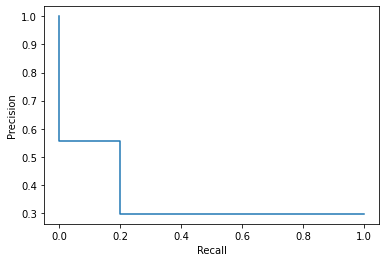

In [34]:
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import PrecisionRecallDisplay

bestmodel_gb.fit(X_train, y_train)
ypred_gb = bestmodel_gb.predict(X_test)
prec_gb, recall_gb, _ = precision_recall_curve(y_test, ypred_gb,
                                         pos_label=bestmodel_gb.classes_[1])
pr_display_gb = PrecisionRecallDisplay(precision=prec_gb, recall=recall_gb).plot()


## Another implementation: 

In [69]:
import itertools

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=0)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        #print("Normalized confusion matrix")
    else:
        1#print('Confusion matrix, without normalization')

    #print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Before OverSampling, counts of label '1': 3608
Before OverSampling, counts of label '0': 8617 

After OverSampling, the shape of train_X: (17234, 61)
After OverSampling, the shape of train_y: (17234,) 

After OverSampling, counts of label '1': 8617
After OverSampling, counts of label '0': 8617
Confusion matrix

 [[1374  770]
 [ 307  606]]

True Positives(TP) =  1374

True Negatives(TN) =  606

False Positives(FP) =  770

False Negatives(FN) =  307
              precision    recall  f1-score   support

           0       0.82      0.64      0.72      2144
           1       0.44      0.66      0.53       913

    accuracy                           0.65      3057
   macro avg       0.63      0.65      0.62      3057
weighted avg       0.70      0.65      0.66      3057

Recall metric in the train dataset: 66.37458926615552%


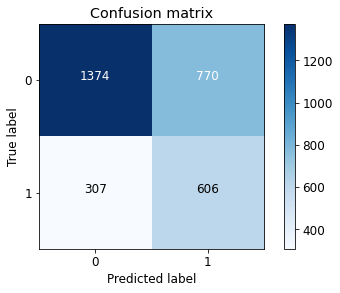

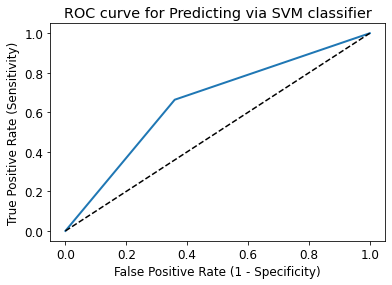

ROC AUC : 0.6523
For fold 1:
Accuracy: 0.647693817468106
f-score: 0.5294888597640892
Before OverSampling, counts of label '1': 3610
Before OverSampling, counts of label '0': 8615 

After OverSampling, the shape of train_X: (17230, 61)
After OverSampling, the shape of train_y: (17230,) 

After OverSampling, counts of label '1': 8615
After OverSampling, counts of label '0': 8615
Confusion matrix

 [[1387  759]
 [ 312  599]]

True Positives(TP) =  1387

True Negatives(TN) =  599

False Positives(FP) =  759

False Negatives(FN) =  312
              precision    recall  f1-score   support

           0       0.82      0.65      0.72      2146
           1       0.44      0.66      0.53       911

    accuracy                           0.65      3057
   macro avg       0.63      0.65      0.62      3057
weighted avg       0.70      0.65      0.66      3057

Recall metric in the train dataset: 65.75192096597146%


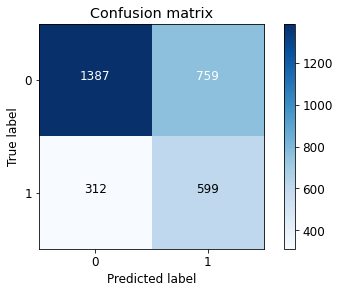

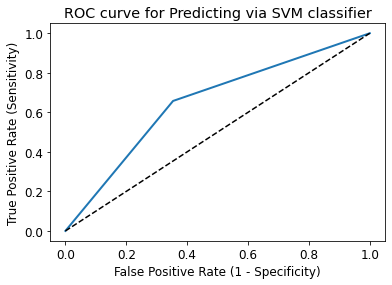

ROC AUC : 0.6519
For fold 2:
Accuracy: 0.6496565260058881
f-score: 0.5279858968708683
Before OverSampling, counts of label '1': 3601
Before OverSampling, counts of label '0': 8625 

After OverSampling, the shape of train_X: (17250, 61)
After OverSampling, the shape of train_y: (17250,) 

After OverSampling, counts of label '1': 8625
After OverSampling, counts of label '0': 8625
Confusion matrix

 [[1345  791]
 [ 329  591]]

True Positives(TP) =  1345

True Negatives(TN) =  591

False Positives(FP) =  791

False Negatives(FN) =  329
              precision    recall  f1-score   support

           0       0.80      0.63      0.71      2136
           1       0.43      0.64      0.51       920

    accuracy                           0.63      3056
   macro avg       0.62      0.64      0.61      3056
weighted avg       0.69      0.63      0.65      3056

Recall metric in the train dataset: 64.23913043478261%


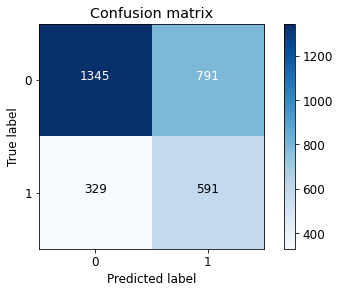

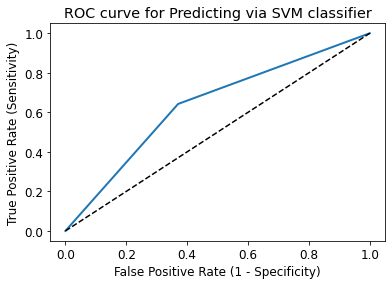

ROC AUC : 0.6360
For fold 3:
Accuracy: 0.6335078534031413
f-score: 0.5134665508253693
Before OverSampling, counts of label '1': 3654
Before OverSampling, counts of label '0': 8572 

After OverSampling, the shape of train_X: (17144, 61)
After OverSampling, the shape of train_y: (17144,) 

After OverSampling, counts of label '1': 8572
After OverSampling, counts of label '0': 8572
Confusion matrix

 [[1429  760]
 [ 301  566]]

True Positives(TP) =  1429

True Negatives(TN) =  566

False Positives(FP) =  760

False Negatives(FN) =  301
              precision    recall  f1-score   support

           0       0.83      0.65      0.73      2189
           1       0.43      0.65      0.52       867

    accuracy                           0.65      3056
   macro avg       0.63      0.65      0.62      3056
weighted avg       0.71      0.65      0.67      3056

Recall metric in the train dataset: 65.28258362168397%


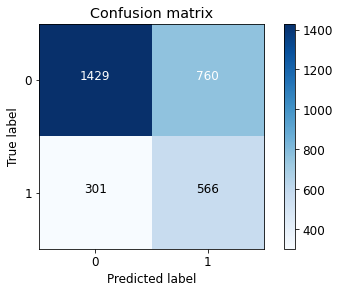

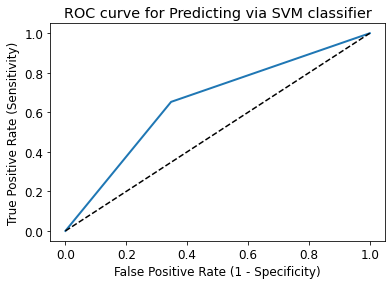

ROC AUC : 0.6528
For fold 4:
Accuracy: 0.6528141361256544
f-score: 0.516187870497036
Before OverSampling, counts of label '1': 3611
Before OverSampling, counts of label '0': 8615 

After OverSampling, the shape of train_X: (17230, 61)
After OverSampling, the shape of train_y: (17230,) 

After OverSampling, counts of label '1': 8615
After OverSampling, counts of label '0': 8615
Confusion matrix

 [[1397  749]
 [ 354  556]]

True Positives(TP) =  1397

True Negatives(TN) =  556

False Positives(FP) =  749

False Negatives(FN) =  354
              precision    recall  f1-score   support

           0       0.80      0.65      0.72      2146
           1       0.43      0.61      0.50       910

    accuracy                           0.64      3056
   macro avg       0.61      0.63      0.61      3056
weighted avg       0.69      0.64      0.65      3056

Recall metric in the train dataset: 61.0989010989011%


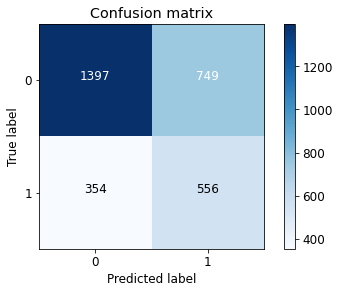

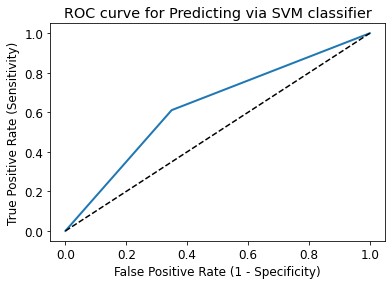

ROC AUC : 0.6310
For fold 5:
Accuracy: 0.6390706806282722
f-score: 0.5020316027088036


In [76]:
from sklearn.model_selection import KFold
from imblearn.over_sampling import SMOTE
from sklearn.metrics import f1_score

kf = KFold(n_splits=5)

for fold, (train_index, test_index) in enumerate(kf.split(X), 1):
    X_train = X[train_index]
    y_train = Y[train_index]
    X_test = X[test_index]
    y_test = Y[test_index]
    sm = SMOTE()
    X_train_oversampled, y_train_oversampled = sm.fit_resample(X_train, y_train)
    model = svm.SVC(C=10, degree=2, kernel='poly')
    model.fit(X_train_oversampled, y_train_oversampled )  
    y_pred = model.predict(X_test)
    
    ####NUMERI OVERSAMPLING###
    print("Before OverSampling, counts of label '1': {}".format(sum(y_train==1)))
    print("Before OverSampling, counts of label '0': {} \n".format(sum(y_train==0)))
    print('After OverSampling, the shape of train_X: {}'.format(X_train_oversampled.shape))
    print('After OverSampling, the shape of train_y: {} \n'.format(y_train_oversampled.shape))
    print("After OverSampling, counts of label '1': {}".format(sum(y_train_oversampled==1)))
    print("After OverSampling, counts of label '0': {}".format(sum(y_train_oversampled==0)))
    
    ####MATRICE DI CONFUSIONE
    cm = confusion_matrix(y_test, y_pred)
    print('Confusion matrix\n\n', cm)
    print('\nTrue Positives(TP) = ', cm[0,0])
    print('\nTrue Negatives(TN) = ', cm[1,1])
    print('\nFalse Positives(FP) = ', cm[0,1])
    print('\nFalse Negatives(FN) = ', cm[1,0])
    print(classification_report(y_test,y_pred))
    
    cnf_matrix_tra = cm
    print("Recall metric in the train dataset: {}%".format(100*cnf_matrix_tra[1,1]/(cnf_matrix_tra[1,0]+cnf_matrix_tra[1,1])))
    class_names = [0,1]
    plt.figure()
    plot_confusion_matrix(cnf_matrix_tra , classes=class_names, title='Confusion matrix')
    plt.show()
    
    ###CURVA ROC####
    fpr, tpr, thresholds = roc_curve(y_test,y_pred)
    plt.figure(figsize=(6,4))
    plt.plot(fpr, tpr, linewidth=2)
    plt.plot([0,1], [0,1], 'k--' )
    plt.rcParams['font.size'] = 12
    plt.title('ROC curve for Predicting via SVM classifier')
    plt.xlabel('False Positive Rate (1 - Specificity)')
    plt.ylabel('True Positive Rate (Sensitivity)')
    plt.show()
    ROC_AUC = roc_auc_score(y_test,y_pred)
    print('ROC AUC : {:.4f}'.format(ROC_AUC))
    
    ###Risultati di ogni fold###
    print(f'For fold {fold}:')
    print(f'Accuracy: {model.score(X_test, y_test)}')
    print(f'f-score: {f1_score(y_test, y_pred)}')

### GBDT: 

Before OverSampling, counts of label '1': 3608
Before OverSampling, counts of label '0': 8617 

After OverSampling, the shape of train_X: (17234, 61)
After OverSampling, the shape of train_y: (17234,) 

After OverSampling, counts of label '1': 8617
After OverSampling, counts of label '0': 8617
Confusion matrix

 [[1590  554]
 [ 459  454]]

True Positives(TP) =  1590

True Negatives(TN) =  454

False Positives(FP) =  554

False Negatives(FN) =  459
              precision    recall  f1-score   support

           0       0.78      0.74      0.76      2144
           1       0.45      0.50      0.47       913

    accuracy                           0.67      3057
   macro avg       0.61      0.62      0.62      3057
weighted avg       0.68      0.67      0.67      3057

Recall metric in the train dataset: 49.72617743702081%


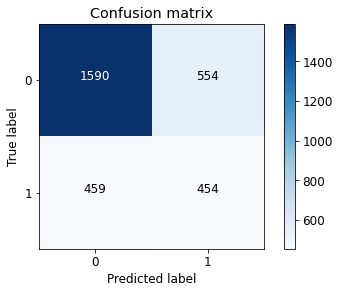

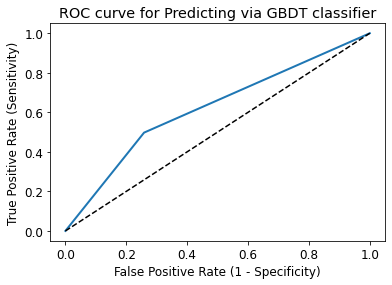

ROC AUC : 0.6194
For fold 1:
Accuracy: 0.6686293752044488
f-score: 0.47267048412285273
Before OverSampling, counts of label '1': 3610
Before OverSampling, counts of label '0': 8615 

After OverSampling, the shape of train_X: (17230, 61)
After OverSampling, the shape of train_y: (17230,) 

After OverSampling, counts of label '1': 8615
After OverSampling, counts of label '0': 8615
Confusion matrix

 [[1571  575]
 [ 445  466]]

True Positives(TP) =  1571

True Negatives(TN) =  466

False Positives(FP) =  575

False Negatives(FN) =  445
              precision    recall  f1-score   support

           0       0.78      0.73      0.75      2146
           1       0.45      0.51      0.48       911

    accuracy                           0.67      3057
   macro avg       0.61      0.62      0.62      3057
weighted avg       0.68      0.67      0.67      3057

Recall metric in the train dataset: 51.15257958287596%


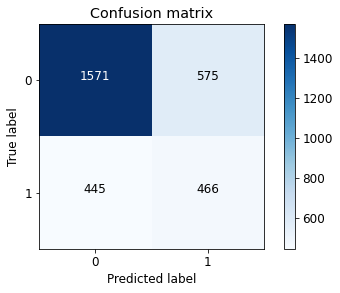

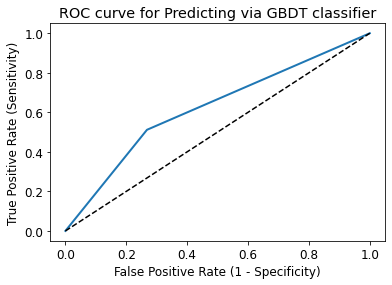

ROC AUC : 0.6218
For fold 2:
Accuracy: 0.6663395485770363
f-score: 0.4774590163934426
Before OverSampling, counts of label '1': 3601
Before OverSampling, counts of label '0': 8625 

After OverSampling, the shape of train_X: (17250, 61)
After OverSampling, the shape of train_y: (17250,) 

After OverSampling, counts of label '1': 8625
After OverSampling, counts of label '0': 8625
Confusion matrix

 [[1569  567]
 [ 441  479]]

True Positives(TP) =  1569

True Negatives(TN) =  479

False Positives(FP) =  567

False Negatives(FN) =  441
              precision    recall  f1-score   support

           0       0.78      0.73      0.76      2136
           1       0.46      0.52      0.49       920

    accuracy                           0.67      3056
   macro avg       0.62      0.63      0.62      3056
weighted avg       0.68      0.67      0.68      3056

Recall metric in the train dataset: 52.06521739130435%


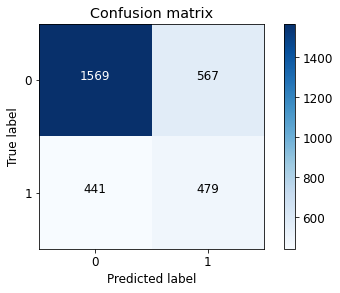

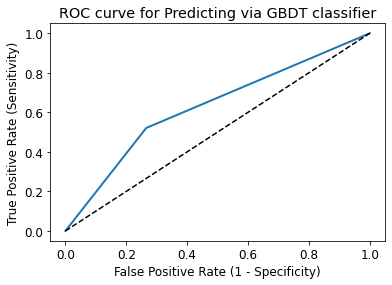

ROC AUC : 0.6276
For fold 3:
Accuracy: 0.6701570680628273
f-score: 0.4872838250254323
Before OverSampling, counts of label '1': 3654
Before OverSampling, counts of label '0': 8572 

After OverSampling, the shape of train_X: (17144, 61)
After OverSampling, the shape of train_y: (17144,) 

After OverSampling, counts of label '1': 8572
After OverSampling, counts of label '0': 8572
Confusion matrix

 [[1651  538]
 [ 424  443]]

True Positives(TP) =  1651

True Negatives(TN) =  443

False Positives(FP) =  538

False Negatives(FN) =  424
              precision    recall  f1-score   support

           0       0.80      0.75      0.77      2189
           1       0.45      0.51      0.48       867

    accuracy                           0.69      3056
   macro avg       0.62      0.63      0.63      3056
weighted avg       0.70      0.69      0.69      3056

Recall metric in the train dataset: 51.095732410611305%


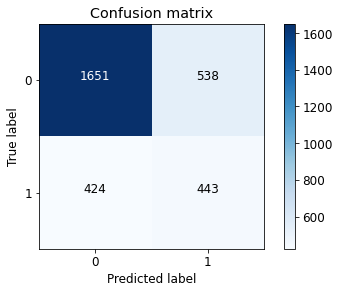

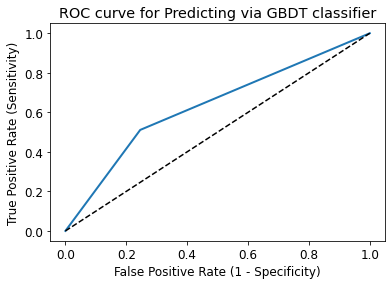

ROC AUC : 0.6326
For fold 4:
Accuracy: 0.6852094240837696
f-score: 0.4794372294372295
Before OverSampling, counts of label '1': 3611
Before OverSampling, counts of label '0': 8615 

After OverSampling, the shape of train_X: (17230, 61)
After OverSampling, the shape of train_y: (17230,) 

After OverSampling, counts of label '1': 8615
After OverSampling, counts of label '0': 8615
Confusion matrix

 [[1629  517]
 [ 472  438]]

True Positives(TP) =  1629

True Negatives(TN) =  438

False Positives(FP) =  517

False Negatives(FN) =  472
              precision    recall  f1-score   support

           0       0.78      0.76      0.77      2146
           1       0.46      0.48      0.47       910

    accuracy                           0.68      3056
   macro avg       0.62      0.62      0.62      3056
weighted avg       0.68      0.68      0.68      3056

Recall metric in the train dataset: 48.13186813186813%


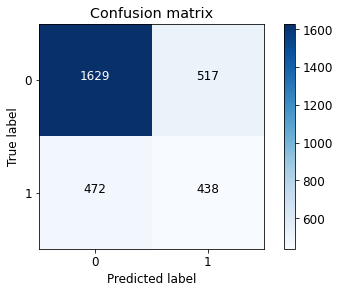

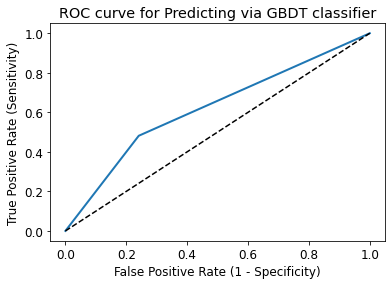

ROC AUC : 0.6202
For fold 5:
Accuracy: 0.6763743455497382
f-score: 0.4697050938337802


In [77]:
for fold, (train_index, test_index) in enumerate(kf.split(X), 1):
    X_trainGB = X[train_index]
    y_trainGB = Y[train_index]
    X_testGB = X[test_index]
    y_testGB = Y[test_index]
    sm = SMOTE()
    X_train_oversampledGB, y_train_oversampledGB = sm.fit_resample(X_trainGB, y_trainGB)
    modelGB = GradientBoostingClassifier(learning_rate=0.25, max_depth=1, n_estimators=250)
    modelGB.fit(X_train_oversampledGB, y_train_oversampledGB )  
    y_predGB = modelGB.predict(X_testGB)
    
    ####NUMERI OVERSAMPLING###
    print("Before OverSampling, counts of label '1': {}".format(sum(y_trainGB==1)))
    print("Before OverSampling, counts of label '0': {} \n".format(sum(y_trainGB==0)))
    print('After OverSampling, the shape of train_X: {}'.format(X_train_oversampledGB.shape))
    print('After OverSampling, the shape of train_y: {} \n'.format(y_train_oversampledGB.shape))
    print("After OverSampling, counts of label '1': {}".format(sum(y_train_oversampledGB==1)))
    print("After OverSampling, counts of label '0': {}".format(sum(y_train_oversampledGB==0)))
    
    ####MATRICE DI CONFUSIONE
    cmGB = confusion_matrix(y_testGB, y_predGB)
    print('Confusion matrix\n\n', cmGB)
    print('\nTrue Positives(TP) = ', cmGB[0,0])
    print('\nTrue Negatives(TN) = ', cmGB[1,1])
    print('\nFalse Positives(FP) = ', cmGB[0,1])
    print('\nFalse Negatives(FN) = ', cmGB[1,0])
    print(classification_report(y_testGB,y_predGB))
    
    cnf_matrix_traGB = cmGB
    print("Recall metric in the train dataset: {}%".format(100*cnf_matrix_traGB[1,1]/(cnf_matrix_traGB[1,0]+cnf_matrix_traGB[1,1])))
    class_names = [0,1]
    plt.figure()
    plot_confusion_matrix(cnf_matrix_traGB , classes=class_names, title='Confusion matrix')
    plt.show()
    
    ###CURVA ROC####
    fprGB, tprGB, thresholdsGB = roc_curve(y_testGB,y_predGB)
    plt.figure(figsize=(6,4))
    plt.plot(fprGB, tprGB, linewidth=2)
    plt.plot([0,1], [0,1], 'k--' )
    plt.rcParams['font.size'] = 12
    plt.title('ROC curve for Predicting via GBDT classifier')
    plt.xlabel('False Positive Rate (1 - Specificity)')
    plt.ylabel('True Positive Rate (Sensitivity)')
    plt.show()
    ROC_AUCGB = roc_auc_score(y_testGB,y_predGB)
    print('ROC AUC : {:.4f}'.format(ROC_AUCGB))
    
    ###Risultati di ogni fold###
    print(f'For fold {fold}:')
    print(f'Accuracy: {modelGB.score(X_testGB, y_testGB)}')
    print(f'f-score: {f1_score(y_testGB, y_predGB)}')